# Title: Enzyme Stability Regression

### Authors: Connor Amato and Sho Takeshita

## Novozymes Enzyme Stability Prediction Kaggle Competition

### Motivation
In industry, enzymes replace chemicals and accelerate production processes. Understanding enzyme stability is a problem in biotechnology, which could help reduce waste, lower costs, and increase production speed.

### Overview
Our goal is to predict the thermostability of proteins, which is measured by their melting points, after single point amino acid mutations and deletions. The relationship between protein type and thermostability is not straightforward, but the amount of disorder (e.g. mutation) in a protein sequence is the main factor according to this publication supplied by the competition: https://www.nature.com/articles/s41592-020-0801-4.
The competition uses Spearman correlation coefficient as the metric for performance.  

### The Dataset
This kaggle competition gives us a training and a test dataset. The dataset contains around 31 thousand records of the variant for one enzyme, sourced from an attempt to atlas the thermal stability of proteins across different types of proteins. The datasets contain for each protein their sequence id (identifies each protein variant), protein sequence (amino acid sequence), pH at which the stability was measured, thermostability (melting point), and a link to the source of the data. The training set includes normal sequences as well as sequences with single or multiple mutations. The submission to the competition is a csv file with the test set along with the classified thermostability. This is a continuous data point so we will be applying some sort of regression model.
## Reading the Data
Here we import the necessary libraries to perform our data exploration. We will be using primarily libraries used in class with the addition of levenshtein for number of mutation calculations adn pyrosetta to calculate the strain energy.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Imported basic libraries
import seaborn as sns
import sklearn as sk
!pip install pyrosettacolabsetup
import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
import pyrosetta; pyrosetta.init()
from pyrosetta import *
!pip install Levenshtein
from Levenshtein import distance as levenshtein_distance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import spearmanr


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
PyRosetta-4 2022 [Rosetta PyRosetta4.MinSizeRel.python38.ubuntu 2022.49+release.201d7639f91f369d58b1adf514f3febaf6154c58 2022-12-07T16:15:33] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.MinSizeRel.python38.ubuntu r337 2022.49+release.201d7639f91 201d7639f91f369d58b1adf514f3febaf6154c58 http://www.pyrosetta.org 2022-12-07T16:15:33
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python3.8/dist-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=1867087824 seed_offset=0 real_seed=1867087824
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=1867087824 RG_type=mt19937
Looking in indexes

Here we read in our training csv file. This provides us with the colums seq_id (protein variant), protein sequence (ammino acid sequence of protein), pH (measure of acidity the protein was recorded in), tm (melting point) and data_source, which gives us the link from which the data was collected.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

def load_fixed_train_df(original_train_file_path="/content/drive/MyDrive/novozymes-enzyme-stability-prediction/train.csv",
                        update_file_path="/content/drive/MyDrive/novozymes-enzyme-stability-prediction/train_updates_20220929.csv",
                        was_fixed_col=False):
    def _fix_tm_ph(_row, update_map):
        update_vals = update_map.get(_row["seq_id"], None)
        if update_vals is not None:
            _row["tm"] = update_vals["tm"]
            _row["pH"] = update_vals["pH"]
        return _row
    
    # Load dataframes
    _df = pd.read_csv(original_train_file_path)
    _updates_df = pd.read_csv(update_file_path)

    # Identify which sequence ids need to have the tm and pH values changed and create a dictionary mapping 
    seqid_2_phtm_update_map = _updates_df[~pd.isna(_updates_df["pH"])].groupby("seq_id")[["pH", "tm"]].first().to_dict("index")

    # Identify the sequence ids that will be dropped due to data quality issues
    bad_seqids = _updates_df[pd.isna(_updates_df["pH"])]["seq_id"].to_list()
    
    # Fix bad sequence ids
    _df = _df[~_df["seq_id"].isin(bad_seqids)].reset_index(drop=True)
    
    # Fix pH and tm swaparoo
    _df = _df.apply(lambda x: _fix_tm_ph(x, seqid_2_phtm_update_map), axis=1)

    # Add in a bool to track if a row was fixed or not (tm/ph swap will look the same as bad data)
    if was_fixed_col: _df["was_fixed"] = _df["seq_id"].isin(bad_seqids+list(seqid_2_phtm_update_map.keys()))
    
    return _df


df = load_fixed_train_df()
df.head(5)
test_df = pd.read_csv('/content/drive/MyDrive/novozymes-enzyme-stability-prediction/test.csv')
df.head(5)

Mounted at /content/drive


,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


Here we drop data source since it is not very useful for us and does not help with calculations or predictions. We also check if there are any null values present in the data.

In [ ]:
df = df.drop("data_source", axis = 1) #This column is not useful to classification
print('Amount of null protein sequences: ',len(df[df["protein_sequence"].isnull()]),
'\nAmount of null tm values: ',len( df[df["tm"].isnull()]),
'\nAmount of null pH values: ',len( df[df["pH"].isnull()])) 
# Each remaining column is perfect except for the 286 missing pH values

Amount of null protein sequences:  0 
Amount of null tm values:  0 
Amount of null pH values:  286


Here we create a distribution plot to see what our target variable looks like. We can see that it is approximately normally distributed, but there is a cummulation of data to the right of the peak of the bell curve. The distributions is centered around a tm of around 50.

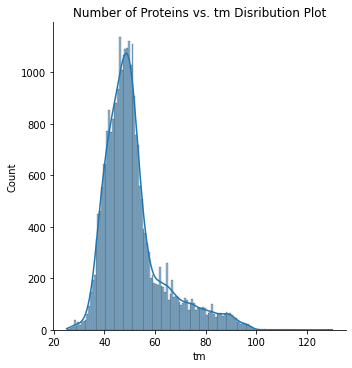

In [ ]:
sns.displot(df['tm'], kde=True).set(title='Number of Proteins vs. tm Disribution Plot') # Let's see the distribution of the classifications 

#(tm is the enzyme melting point and is a measure of stability)

Here we create anouther distribution plot to see what the distrubution of pH looks like among proteins. It seems that the data has a massive peak around a pH of 7 and most of the data is concentrated at that peak and below. Note that pH is on a scal from 0-14. There were no pHs below 2, so we set the scale to start at 2 on the x axis. The plot looks normally distributed.

(2.0, 14.0)

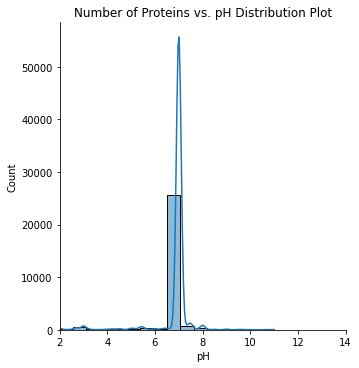

In [ ]:
sns.displot(df['pH'], kde=True).set(title='Number of Proteins vs. pH Distribution Plot')
plt.xlim(right=14,left=2)

In [ ]:
print(len(df), " Total Rows vs ", len(df["protein_sequence"].unique()), " Unique Sequences")

28981  Total Rows vs  27375  Unique Sequences


Here we plot a scatter plot of the length of the protein sequence vs the melting point. As the length of the protein sequence gets longer the melting point temperature tends to get concentrated around 50. This is a very interesting observation and could be an important feature to consider. It almost looks like a normal distribution turned sideways.

coorelation: -0.1375036328435403


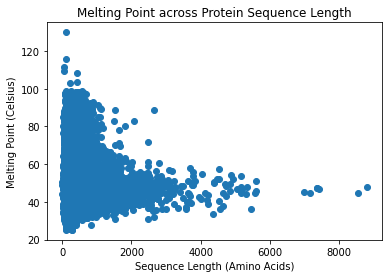

In [ ]:
plt.scatter(df["protein_sequence"].apply(lambda x : len(x)), df["tm"])
plt.title("Melting Point across Protein Sequence Length")
plt.xlabel("Sequence Length (Amino Acids)")
plt.ylabel("Melting Point (Celsius)")
print("coorelation: " + str(df["tm"].corr(df["protein_sequence"].apply(lambda x : len(x))))) 
# looks like no relation, we can ignore the length of sequences

This is the base wild type sequence provided in the description of the competition. We use this as the wildtype for the test data, since the test data is only from one protein.


In [ ]:

base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
len(base)

221

## Parsing
The protein sequence feature is almost entirely made of of unique values, so we need to parse this into multiple more useful features. To do this, we will employ the PyRosseta library, which supplies funcitonality for dealing with molecular biology information. 

Using Rosetta's scoring, let's get the energy balance and number of atoms from each amino acid present in the base sequence. This will be useful later for numeralizing the mutations. Lower energies are more stable.

In [ ]:
pyrosetta.init()
score_func = pyrosetta.get_score_function(True) # Used for scoring amino acids in pyRosetta
energy_dict = {}
atoms_dict = {}
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'] # All amino acid abbreviations
for aa in amino_acids: # For each amino acid, make two dictionary entries
    pose = pose_from_sequence(str(aa), 'fa_standard') # making use of rosetta suite to help with chemistry calculations
    energy_dict[aa] = score_func(pose) #total energy
    atoms_dict[aa] = pose.total_atoms() #total number of atoms in the amino acid
    print(str(aa) + " - energy: " + str(energy_dict[aa]) + ", # atoms: " + str(atoms_dict[aa]))

PyRosetta-4 2022 [Rosetta PyRosetta4.MinSizeRel.python38.ubuntu 2022.49+release.201d7639f91f369d58b1adf514f3febaf6154c58 2022-12-07T16:15:33] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.MinSizeRel.python38.ubuntu r337 2022.49+release.201d7639f91 201d7639f91f369d58b1adf514f3febaf6154c58 http://www.pyrosetta.org 2022-12-07T16:15:33
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python3.8/dist-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=956799720 seed_offset=0 real_seed=956799720
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=956799720 RG_type=mt19937
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
A - energy: 1.3271969948449436, # atoms: 13
R - energy: 102.31

## Grouping Sequences
The train data contains thousands of sequences that are not grouped properly.
To assign an original wildtype sequence to the training data, we will emply the use of the train wildtype groups csv file containing all wiltypes present in the training data. 

In [ ]:
drive.mount('/content/drive')
wildtype_groups = pd.read_csv("/content/drive/MyDrive/novozymes-enzyme-stability-prediction/train_wildtype_groups.csv") #https://www.kaggle.com/datasets/shlomoron/train-wildtypes-af?select=train_wildtype_groups.csv 
wildtypes = wildtype_groups["wildtype"].unique()
len(wildtypes) # There are 78 unique wildtypes in the training data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


78

To group each sequence into a wildtype group, we need to emply a string difference algorithm. We have chosen the levenshtein distance because we do not care about what place each character is in, just the amount of additions or deletions. The function 'group_wildtypes' takes a protein sequence from the data and assigns it an original wildtype from the 78 wildtypes present in the data. As long as the sequence is about as long as the wildtype (within 5 amino acids), and has a max of 20 mutations, it is a good candidate for the wildtype.

In [ ]:

df["wildtype"] = -1 

def group_wildtypes(seq): #Imperative function for grouping a sequence to one of the 78 provided wild types
  for idx in range(len(wildtypes)):
    wt = wildtypes[idx]
    ld = levenshtein_distance(wt, seq)
    if ((len(seq) > (len(wt) - 6)) and (len(seq) < (len(wt) + 6))) and ld < 20:
      return int(idx)
      # Assign if and only if the sequence length is near the wildtype length,
      # and total mutations are under 20 from the original wildtype
      
df["wildtype"] = df["protein_sequence"].apply(group_wildtypes) 
# run this function for every sequence to assign as many wildtypes as we can

print(df["wildtype"].value_counts())
df.dropna(inplace=True)
df['wildtype'] = df['wildtype'].apply(lambda x: int(x))


0.0     708
1.0     273
2.0     211
3.0     194
4.0     180
       ... 
73.0      6
75.0      6
74.0      6
76.0      6
77.0      5
Name: wildtype, Length: 77, dtype: int64


### Energy Calculations
Amino acid mutations can cause partial or total unfolding of a protein, which can cause disease states, and unfolding is also an indication of melting. So it is useful to predict which mutants can retain the conformation of a wild type protein, and which cannot. So, we used relative strain to relate to the risk of folding, which is the stability of the mutant relative to the wild type protein. 

Using the dictionaries for each amino acid and their energy and number of atoms, we will calculate the strain energy of each protein. The relative strain, S, in the mutant protein was computed as:
#### (Emut/Nmut − Ewt/Nwt)/(Ewt/Nwt) = E¯mut/E¯wt − 1
Nwt and Nmut are the number of atoms in the wild-type and mutant proteins, respectively. [Paper with equation](https://academic.oup.com/peds/article/14/7/479/1551044?login=true)

In this imperative function, we assign each row a relative strain value as well as an energy value that represents the net gain in energy from the mutaiton.

In [ ]:
def calc_energy(data, bool): 
  # bool = True for train data False for Test data
  # data = dataframe
  energy_changes = []
  strains = []
  for row in data.iterrows():
    seq = row[1]["protein_sequence"]
    wt = wildtypes[int(row[1]["wildtype"])] if bool else base
    # For the test data, we already know the wild type so assign it base
    flag1 = True
    flag2 = False #setting up flags for logic to only get first mutation
    count = 0
    muts = []
    wts = []
    for i in range(min(len(wt), len(seq))):
      if flag1 and (wt[i] != seq[i]): #If mutation (only first mutation strain)
        count = count + 1
        muts.append(seq[i])
        wts.append(wt[i])
        flag2 = True
      else: 
        if flag2: #If we found first mutation strain, cut off the buffer
          flag1 = False
    energy_change = 0
    strain_change = 0
    for j in range(len(muts)): #For every amino acid in the mutation strain
      emut = energy_dict[muts[j]] # get energy of mutation
      ewt = energy_dict[wts[j]] # get energy of wild type
      e_net = emut - ewt # net energy, store this as a feature
      nmut = atoms_dict[muts[j]] # get number of atoms in mutation
      nwt = atoms_dict[wts[j]] # get number of atoms in wild type
      e_bar = (emut/nmut - ewt/nwt) / (ewt/nwt) # Formula from study
      energy_change = energy_change + e_net
      strain_change = strain_change + e_bar
    energy_changes.append(energy_change)
    strains.append(strain_change)
  data["energy"] = energy_changes
  data["strain"] = strains

calc_energy(df, True)

Now lets add a feature for sequence length, so the machine can differentiate between wildtypes.

In [ ]:
df["seq_length"] = df["protein_sequence"].apply(lambda x : len(x)) # get sequence length for every sequence

Here we drop any protein that was not assigned a wildtype so that we dont have any missing data points wildtype column.

In [ ]:
df = df[df["wildtype"] != -1]
df

,seq_id,protein_sequence,pH,tm,wildtype,energy,strain,seq_length
252,266,AKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,58.0,25,-37.244504,-0.947064,53
947,972,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,45.2,8,22.494034,1.607760,96
948,973,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,48.4,8,22.494034,1.607760,96
949,974,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,48.0,8,22.494034,1.607760,96
956,982,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQAGVVFQNRESVLPT...,7.0,31.8,8,-21.264404,-0.932215,96
...,...,...,...,...,...,...,...,...
28193,30597,SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVAKDF...,2.5,71.7,76,-38.038304,-0.955912,68
28194,30598,SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...,2.5,62.6,76,-100.988860,-0.973059,68
28195,30599,SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...,2.5,59.2,76,-58.476759,-0.537253,68
28196,30600,SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...,2.5,65.7,76,-100.988860,-0.973059,68


Here we have to drop missing values so that we can run our machine learning algorithm and we also have to drop the columns that we won't be using as features.

In [ ]:
df.dropna(axis=0,how='any',inplace=True)
copy_df = df.copy("deep")
df.drop(['seq_id','protein_sequence'], axis=1, inplace=True)

## Exploratory Data Analysis

Here we make a heat map to look at the correlation between different variables.

[Text(0.5, 1.0, 'Covariance Matrix')]

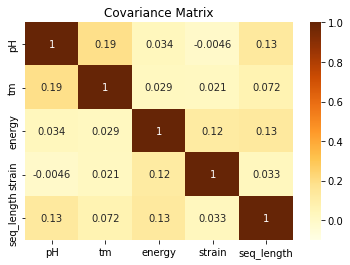

In [ ]:
sns.heatmap(df.drop(["wildtype"], axis = 1).corr(), 
            cmap="YlOrBr", robust = True, annot = True, vmin = -.1).set(title = "Covariance Matrix")

And another heatmap for a specific wildtype. It is apparent that the correlation between features and the metling point depends on the wildtype.

[Text(0.5, 1.0, 'Covariance Matrix')]

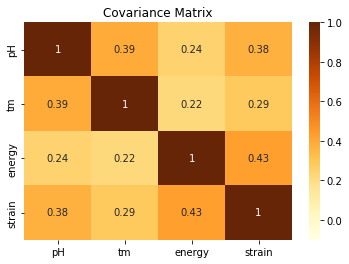

In [ ]:
sns.heatmap(df[df["wildtype"] == 9].drop(["wildtype", "seq_length"], 
            axis = 1).corr(), cmap="YlOrBr", robust = True, annot = True, vmin = -.1).set(title = "Covariance Matrix")

## Machine Learning

Here we perform our train test split so that we can see how our regression performs later.

In [ ]:
x=df.drop(['wildtype', 'tm'],axis=1)
y=df['tm']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20)

Here we initialize the random forest regressor and then print out the parameters to decide which parameters to test in our grid search. We chose to train a Random Forest Regressor for 3 main reasons
* Our target variable, melting point (tm), is continuous data, so we need a regression model instead of a classification model
* Has many meta parameters that can be used to prevent overfitting and increase accuracy
* Random Forests can handle large data sets efficiently


In [ ]:

rf = RandomForestRegressor()
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Here we decide our parameters for our grid search.

In [ ]:
grid = {'max_depth':list(np.arange(1, 20, step=2)),
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':np.arange(1,5, step=1),
              'min_samples_leaf':np.arange(1,6, step=1),
              'min_samples_split':np.arange(2, 12, step=2)
         } # grid search for best parameters 

We run our grid search with 10 fold cross validation. We use r^2 for our scoring.

In [ ]:
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=grid, 
                              n_jobs = -1,
                              scoring='r2', 
                              cv = 10, verbose=2,
                              return_train_score=True)

Here we fit our model with our training data.

In [ ]:
grid_search.fit(x_train,y_train) # Train regression model

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15,
                                                      17, 19],
                                        'max_features': array([1, 2, 3, 4]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460])},
                   return_train_score=True, scoring='r2', verbose=2)

Here we read in our test dataset and then perform the distance and energy calculations on it in order to predict the melting points. We then saved the prediction in the submission dataframe and saved it as a csv to submit for the competition. The competition will calculate our score.

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/novozymes-enzyme-stability-prediction/test.csv')
submission = pd.DataFrame()
submission['seq_id'] = test_df['seq_id']
test_df["seq_length"] = test_df["protein_sequence"].apply(lambda x: len(x))
calc_energy(test_df, False)
test_df.drop(columns=['seq_id','protein_sequence', 'data_source'], axis=1, inplace=True)
#Now that we have created the same features for the test data, 
submission['tm'] = grid_search.predict(test_df) # Use the model to predict it
submission.to_csv('submission.csv',index=False)
print(submission.head(5))

   seq_id         tm
0   31390  39.401292
1   31391  39.401292
2   31392  39.401292
3   31393  39.401292
4   31394  39.401292


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
submission["tm"].unique() # Make sure we have unique values (mutations can be very similar)

array([39.40129202, 39.79708327, 38.93019354, 39.87624994, 40.06099994,
       39.63208327])

Here we run our prediciton on the test data from our split and then print out the resulting spearmanr correlation coefficient. Our score is 0.838, which is a decent score. This spearman correlation coefficient had a P-value of 4 x 10 ^ -209, which is extremely close to zero indicating the statistical significance of our regression model at a high confidence.

In [ ]:
pred = grid_search.predict(x_test) #How did we do on split train data?
stats.spearmanr(y_test, pred)

SpearmanrResult(correlation=0.8303855210407611, pvalue=1.4027993689645268e-201)

###Residuals
Plot of average residuals across each wildtype

In [ ]:
x_test["Predictions"] = pred
x_test["Actual"] = y_test
x_test

,pH,energy,strain,seq_length,Predictions,Actual
12984,7.5,-15.441359,-0.914764,53,49.603170,63.4
15543,7.0,22.494034,1.607760,231,48.455632,42.6
957,7.0,-21.264404,-0.932215,96,46.871756,52.6
14750,3.2,24.631272,11.713263,155,49.689171,41.2
14729,3.0,-1.313790,-0.168959,155,49.983247,48.8
...,...,...,...,...,...,...
17321,7.0,-15.441359,-0.914764,296,51.901007,56.0
10452,8.0,0.949374,0.021586,537,73.495872,72.9
16942,5.4,37.244504,17.890644,164,62.166630,60.1
17643,8.0,-26.504369,-1.017792,455,61.261666,62.0


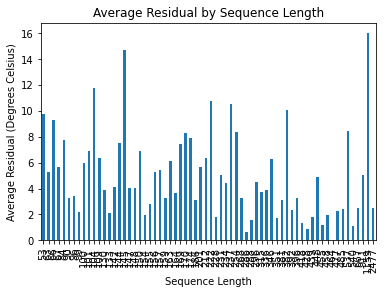

In [ ]:

x_test["residual"] = abs(x_test["Predictions"] - x_test["Actual"])
gby = x_test.groupby("seq_length")["residual"].mean()
gby.plot(kind='bar', title='Average Residual by Sequence Length',
               ylabel='Average Residual (Degrees Celsius)', xlabel='Sequence Length')

### Predictions vs Accuracy
Plot of predicted melting points versus actual melting points along an x-axis of sequence length 

(0.0, 750.0)

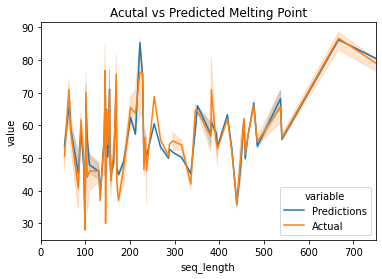

In [ ]:
sns.lineplot(x='seq_length', y='value', hue='variable', 
             data=pd.melt(x_test.drop(["strain", "residual", "pH", "energy"], axis = 1), ['seq_length'])).set(
                 title = "Acutal vs Predicted Melting Point"
             )
plt.xlim(0, 750)

# Conclusion
Based on our spearman correlation coefficient of 0.838, which is based on our split test data and training data, our predicitions were pretty accurate. However, when we tried predicting the test data it seems that our predictions was pretty terrible. We did not rank as highly as we would have liked in the competition. The test data only has variants of one protein, which is not present in our data. Other teams probably had more knowledge in how to extrapilate across wildtypes based on simply the relational protein sequences. Our model had a hard time adjusting to novel wildtypes, since it had not seen them before.  It is easy for our model to adjust once it has been shown a wildtype, though. Given information about a wildtype, its mutations, and its melting points makes predicting melting points straightforward. Taking the same information and predicting another wildtype's melting point is very difficult as different protein wildtypes behave so different, and this variability in behavior is evident even in the small sample of 78 wildtypes in this dataset. Perhaps this is also further proof that the energy calculations are either not very good at determining relative strain in proteins, or that relative strain in proteins does not correlate well with melting point temperature.

## Final Thoughts
Through this competition and final project, we have discovered that to perform the data science process most effectively, extensive knowledge or even expertise in the field of the dataset is often required. In this dataset it is evidently clear that only experts in protein mutations would be able to provide the neccesary information about every factor in protein melting points. Nontheless, our methods show that research and proper data science technique is enough to get simpler but useful insights from important information.